In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torchvision.datasets import CocoCaptions
from torch.utils.data import DataLoader, Dataset, Subset
from safetensors.torch import load_file
from diffusers import AutoencoderKL, UNet2DConditionModel, DPMSolverMultistepScheduler
from transformers import CLIPTokenizer, CLIPTextModel
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

c:\Users\HanDong\Documents\Study\Semester 6 - OJT\image_fusion_generation\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CNNBranch(nn.Module):
    def __init__(self, in_channels=3, feature_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, feature_dim, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.encoder(x)


class HybridEncoder(nn.Module):
    def __init__(self, cnn_channels=3, feature_dim=128):
        super().__init__()
        self.cnn1 = CNNBranch(cnn_channels, feature_dim)
        self.cnn2 = CNNBranch(cnn_channels, feature_dim)

    def forward(self, img1, img2):
        # Extract CNN features
        feat1 = self.cnn1(img1)  # [B, 3, 256, 256]
        feat2 = self.cnn2(img2)
        fused = (feat1 + feat2) / 2
        B, C, H, W = fused.shape
        # flatten spatial dims -> tokens: [B, H*W, C]
        tokens = fused.view(B, C, H * W).permute(0, 2, 1).contiguous()
        return tokens  # [B, N_img, feat_dim] where N_img = H*W


class FusionSDTurboModel(nn.Module):
    def __init__(self, encoder: nn.Module,
                 pretrained_model="stabilityai/sd-turbo",
                 text_encoder_model="openai/clip-vit-base-patch32",
                 device="cuda",
                 fusion_transformer_layers=2,
                 fusion_transformer_heads=8):
        super().__init__()
        self.device = device
        self.encoder = encoder  # returns image tokens [B, N_img, feat_dim]

        # Pretrained SD-Turbo components
        self.vae = AutoencoderKL.from_pretrained(pretrained_model, subfolder="vae").to(device)
        self.unet = UNet2DConditionModel.from_pretrained(pretrained_model, subfolder="unet").to(device)
        self.scheduler = DPMSolverMultistepScheduler.from_pretrained(pretrained_model, subfolder="scheduler")
        self.unet.enable_gradient_checkpointing()

        # CLIP text encoder
        self.tokenizer = CLIPTokenizer.from_pretrained(text_encoder_model)
        self.text_encoder = CLIPTextModel.from_pretrained(text_encoder_model, use_safetensors=True).to(device)
        clip_dim = self.text_encoder.config.hidden_size  # typically 512

        # target cross-attention dim expected by UNet
        cross_dim = self.unet.config.cross_attention_dim  # 1024

        # Projectors: map image-token-dim and clip_dim -> cross_dim
        if hasattr(encoder.cnn1.encoder[-2], 'out_channels'):
            self.img_proj = nn.Linear(encoder.cnn1.encoder[-2].out_channels, cross_dim)
        else:
            self.img_proj = nn.Linear(encoder.cnn1.encoder[2].out_channels, cross_dim)

        # text projection: 512 -> cross_dim
        self.text_proj = nn.Linear(clip_dim, cross_dim)

        # Small transformer to mix image/text tokens (operates in cross_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=cross_dim, nhead=fusion_transformer_heads, batch_first=True)
        self.fusion_transformer = nn.TransformerEncoder(encoder_layer, num_layers=fusion_transformer_layers)

        # Resize inputs to 256x256
        self.upsample = T.Resize((256, 256), interpolation=T.InterpolationMode.BICUBIC)

        # Latent scaling factor
        self.latent_scale = self.vae.config.scaling_factor

        self.cross_dim = cross_dim

    def encode_text(self, prompts):
        inputs = self.tokenizer(prompts, padding="max_length", max_length=77,
                                truncation=True, return_tensors="pt").to(self.device)
        text_embeds = self.text_encoder(**inputs).last_hidden_state  # [B, seq_len, 768]
        return text_embeds

    def encode_latents(self, x):
        with torch.no_grad():
            latents = self.vae.encode(x).latent_dist.sample()
        return latents * self.latent_scale

    def decode_latents(self, latents):
        latents = latents / self.latent_scale
        imgs = self.vae.decode(latents).sample
        return imgs
    
    def build_conditioning(self, img1, img2, prompts):
        img_tokens = self.encoder(img1, img2)  # [B, N_img, feat_dim]
        
        # project image tokens -> cross_dim
        img_tokens_proj = self.img_proj(img_tokens)  # [B, N_img, cross_dim]

        # text tokens
        text_tokens = self.encode_text(prompts)  # [B, seq_len, clip_dim]
        text_tokens_proj = self.text_proj(text_tokens)  # [B, seq_len, cross_dim]

        # concat -> [B, N_img + seq_len, cross_dim]
        cond_tokens = torch.cat([text_tokens_proj, img_tokens_proj], dim=1)

        # fusion transformer mixing (optional)
        cond_fused = self.fusion_transformer(cond_tokens)  # [B, N_total, cross_dim]
        return cond_fused

    def forward(self, img1, img2, target, timesteps, prompts):
        # Upsample to 256x256
        img1 = self.upsample(img1)
        img2 = self.upsample(img2)
        target = self.upsample(target)

        # build conditioning tokens (projected -> fused -> cross_dim)
        cond = self.build_conditioning(img1, img2, prompts)  # [B, N_total, cross_dim]

        # encode target -> latents
        latents = self.encode_latents(target)  # [B, latent_c, latent_h, latent_w]

        # sample noise and add using scheduler (diffusers scheduler supports add_noise)
        noise = torch.randn_like(latents)
        noisy_latents = self.scheduler.add_noise(latents, noise, timesteps)

        # pass through UNet (UNet expects encoder_hidden_states with shape [B, seq_len, cross_dim])
        noise_pred = self.unet(noisy_latents, timesteps, encoder_hidden_states=cond).sample

        return noise_pred, noise, latents

In [3]:
def freeze_module(module):
    for p in module.parameters():
        p.requires_grad = False

In [ ]:
class FusionCocoDataset(Dataset):
    def __init__(self, root, annFile, transform=None, alpha_range=(0.3, 0.7)):
        self.coco = CocoCaptions(root=root, annFile=annFile, transform=None)
        self.transform = transform
        self.alpha_range = alpha_range  # controls blending strength

    def __len__(self):
        return len(self.coco)

    def __getitem__(self, idx):
        # First image + captions
        img1, captions1 = self.coco[idx]
        caption1 = random.choice(captions1)

        # Pick a different random image
        idx2 = random.randint(0, len(self.coco) - 1)
        while idx2 == idx:
            idx2 = random.randint(0, len(self.coco) - 1)
        img2, captions2 = self.coco[idx2]
        caption2 = random.choice(captions2)

        # Convert both to same size (required for blending)
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        else:
            img1 = T.ToTensor()(img1)
            img2 = T.ToTensor()(img2)

        # Create fusion target (alpha blend)
        alpha = random.uniform(*self.alpha_range)
        target = alpha * img1 + (1 - alpha) * img2
        target = target.clamp(0, 1)  # keep valid pixel range

        # Combine captions into fusion prompt
        fusion_caption = f"{caption1} and {caption2}"

        return img1, img2, target, fusion_caption

In [ ]:
def train_model(model, dataloader, optimizer, device="cuda", num_epochs=5):
    model.to(device)
    
    # Freeze VAE + UNet + tokenizer + text_encoder
    freeze_module(model.vae)
    freeze_module(model.unet)
    freeze_module(model.text_encoder)

    scaler = torch.amp.GradScaler(device)
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for img1, img2, target, captions in pbar:
            img1, img2, target = img1.to(device), img2.to(device), target.to(device)

            # Random timestep for diffusion
            bsz = img1.size(0)
            timesteps = torch.randint(0, 100, (bsz,), device=device, dtype=torch.long)

            optimizer.zero_grad()

            # Mixed precision forward
            with torch.amp.autocast(device, dtype=torch.float16):
                noise_pred, noise, latents = model(img1, img2, target, timesteps, captions)
                loss = criterion(noise_pred, noise)

            # Backward + optimizer step
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            pbar.set_postfix({"loss": loss.item()})

        # save checkpoint
        torch.save(model.state_dict(), f"checkpoint/fusion_model_epoch{epoch+1}.pt")


In [32]:
def denorm(x):
    return (x.clamp(-1, 1) + 1) / 2  # [-1,1] -> [0,1]


@torch.no_grad()
def sample_images(model, dataloader, device="cuda", num_samples=5, num_inference_steps=25, guidance_scale=7.5):
    model.eval()
    model.to(device)

    img1, img2, target, prompt= next(iter(dataloader))
    img1, img2, prompt = img1[:num_samples], img2[:num_samples], prompt[:num_samples]
    img1, img2 = img1.to(device), img2.to(device)
    
    # encode conditioning (image+text)
    cond = model.build_conditioning(img1, img2, prompt)  # [B, N, cross_dim]

    # start from random Gaussian latents
    B, _, H, W = num_samples, 4, 32, 32   # default SD VAE latent shape: [B,4,32,32] for 256x256 images
    latents = torch.randn((B, 4, H, W), device=device)

    # Prepare scheduler timesteps
    model.scheduler.set_timesteps(num_inference_steps)
    timesteps = model.scheduler.timesteps.to(device)

    # Iterative denoising loop
    for t in timesteps:
        # Predict noise
        noise_pred = model.unet(latents, t, encoder_hidden_states=cond).sample

        # CFG (classifier-free guidance) - run with empty prompt as unconditional
        uncond = model.build_conditioning(img1, img2, [""] * B)
        noise_pred_uncond = model.unet(latents, t, encoder_hidden_states=uncond).sample

        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred - noise_pred_uncond)

        # Step through scheduler
        latents = model.scheduler.step(noise_pred, t, latents).prev_sample

    # Decode to images
    imgs = model.decode_latents(latents)  # [-1,1]

    # Plot results
    for i in range(num_samples):
        print(prompt[i])
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(denorm(img1[i]).permute(1, 2, 0).cpu())
        axes[0].set_title("Input 1")
        axes[0].axis("off")

        axes[1].imshow(denorm(img2[i]).permute(1, 2, 0).cpu())
        axes[1].set_title("Input 2")
        axes[1].axis("off")
        
        axes[2].imshow(denorm(imgs[i]).permute(1, 2, 0).cpu())
        axes[2].set_title(f"Generated")
        axes[2].axis("off")

        plt.show()


In [7]:
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)  # normalize to [-1,1]
])

# COCO 2017 train set (download beforehand!)
dataset = FusionCocoDataset(
    root="data/coco/val2017",
    annFile="data/coco/annotations/captions_val2017.json",
    transform=transform
)
# use a 1000-image subset for quick testing
subset = Subset(dataset, range(1000))
dataloader = DataLoader(subset, batch_size=16, shuffle=True, pin_memory=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Model & optimizer
encoder = HybridEncoder()
model = FusionSDTurboModel(encoder, device=device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Using device: cuda


In [8]:
train_model(model, dataloader, optimizer, device=device, num_epochs=10)

Epoch 1/10: 100%|██████████| 63/63 [2:41:02<00:00, 153.38s/it, loss=0.0556]  


RuntimeError: Parent directory checkpont does not exist.

In [9]:
torch.save(model.state_dict(), f"checkpoint/fusion_model_epoch1.pt")

An office desk with a row of books and a desktop computer and laptop computer on the desk. and A little girl walking along a row of orange cones.


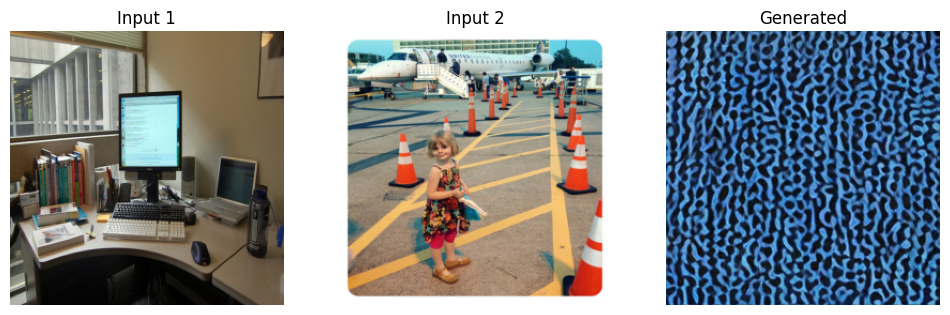

In [33]:
sample_images(model, dataloader, device=device, num_samples=1, num_inference_steps=50)

In [ ]:
# # # Free memory
# import torch
# torch.cuda.empty_cache()
# torch.cuda.ipc_collect()